This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is a unbalanced biggest dataset that combines all hospitals previously used by retain, with 494,528 patients in total
* The logistic regression model has the architecture of an embedding layer (embedding dimension =1), a linear activation and sigmoid transformation
* Our model achieves overall 0.7650 test auc (visits < 5: 0.7508 test auc, visit >= 5: 0.7839 test auc), with corresponding 0.7679 validation auc on epoch 10
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce    

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004)
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [6]:
"""
train1 , valid1, test1 = data_load_split_VT()
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))


"""

101567 14509 29019


In [ ]:
#to dump
"""
#to dump
pickle.dump(train1, open('hf50_unb_train', 'wb'), -1)
pickle.dump(valid1, open('hf50_unb_valid', 'wb'), -1)
pickle.dump(test1, open('hf50_unb_test', 'wb'), -1)

"""

In [5]:
#to reload:
train1 = pickle.load(open('hf50_unb_train', 'rb'), encoding='bytes')
valid1 = pickle.load(open('hf50_unb_valid', 'rb'), encoding='bytes')
test1= pickle.load(open('hf50_unb_test', 'rb'), encoding='bytes')
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))#### 346171 49452 98905 

346171 49452 98905


In [6]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[16067, 15091, 16072, 11765, 14458, 12611, 16078, 4750, 12066, 652, 857, 7258, 1201, 1196], [15091, 14458], [16067, 16072, 11765, 3822, 16078, 4750, 12026, 2910, 1201, 1196], [16067, 16072, 11765, 15499, 14475, 11857, 11892, 11893, 2691, 16078, 13913, 11756, 2361, 1201, 1196], [16067, 15091, 16072, 11765, 14458, 7592, 3822, 16078, 12026, 1201]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [16072, 5702, 16078, 16063, 16072, 5702, 16078, 16064, 16072, 5701, 16078, 16064, 16072, 5702, 16078, 16064, 16072, 5702, 16078, 16064, 15051, 14538, 13871, 16072, 15376, 14506, 14815, 15219, 15324, 15130, 13838, 15383, 5703, 14401, 14541, 16078, 15105, 14618, 13833, 16064, 14647, 15175, 4499, 15152, 14735, 15445, 14203, 14003, 14934, 15499, 11781, 15006, 14782, 14725, 16072, 5703, 16078, 16064]]
[1, [5316, 14454, 15497, 15478, 14763

In [7]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
 1.6920e+00
 1.0831e-02
-3.8142e-01
     ⋮      
-7.7575e-01
 1.5551e+00
-4.8969e-01
[torch.FloatTensor of size 20000x1]

        emb                           types
0  1.691976                            Code
1  0.010831  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -0.381424         b'M_BACITRACIN TOPICAL'
3  1.000919    b'M_BUPIVACAINE-EPINEPHRINE'
4  0.248113                  b'M_CEFAZOLIN'


In [8]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [9]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.3706318341898887


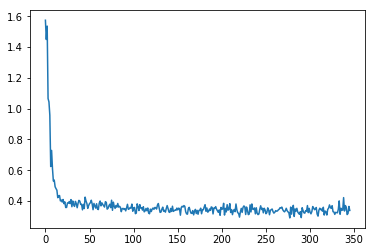

Epoch  0 Summary:  Training_auc : 0.7698094137961476  , Validation_auc :  0.767401821217583  ,Test_auc :  0.7643341934492514 Test_auc on short visits: 0.752810083350087 Test_auc on long visits: 0.7821099258539097  Avg Loss:  0.3706318341898887 Train Time (7m 35s) Eval Time (3m 46s)

 Current running on: Epoch  1 Training loss:  Average loss 0.3394229625137824


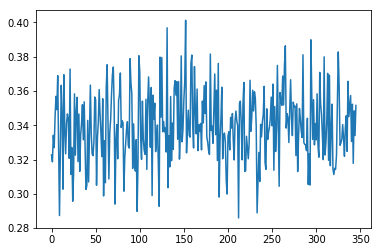

Epoch  1 Summary:  Training_auc : 0.7622346990157272  , Validation_auc :  0.7594565662407747  ,Test_auc :  0.7570023090098246 Test_auc on short visits: 0.746272599511982 Test_auc on long visits: 0.7751224578619874  Avg Loss:  0.3394229625137824 Train Time (7m 9s) Eval Time (3m 42s)

 Current running on: Epoch  2 Training loss:  Average loss 0.33938596814438393


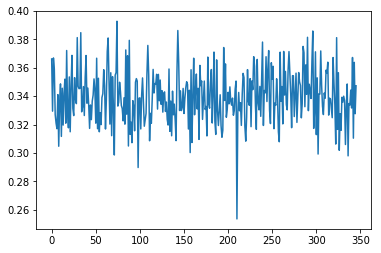

Epoch  2 Summary:  Training_auc : 0.7644845449365765  , Validation_auc :  0.7632175336143223  ,Test_auc :  0.7607595526038088 Test_auc on short visits: 0.7479882604674353 Test_auc on long visits: 0.7798029613263546  Avg Loss:  0.33938596814438393 Train Time (7m 1s) Eval Time (3m 40s)

 Current running on: Epoch  3 Training loss:  Average loss 0.33933961747141383


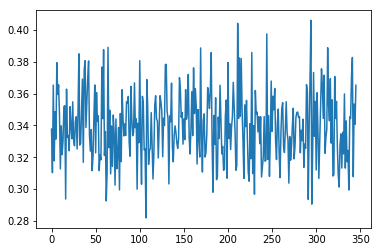

Epoch  3 Summary:  Training_auc : 0.7697206319041083  , Validation_auc :  0.7670803657724047  ,Test_auc :  0.7643002588689288 Test_auc on short visits: 0.7484663213073249 Test_auc on long visits: 0.7834181569722076  Avg Loss:  0.33933961747141383 Train Time (7m 7s) Eval Time (4m 27s)

 Current running on: Epoch  4 Training loss:  Average loss 0.3394657134664078


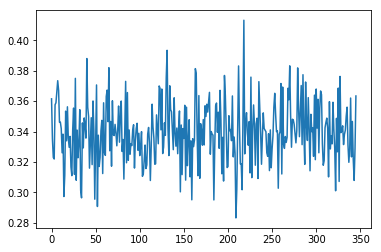

Epoch  4 Summary:  Training_auc : 0.7674070184810319  , Validation_auc :  0.7644892520759303  ,Test_auc :  0.762324781547914 Test_auc on short visits: 0.7505892670765488 Test_auc on long visits: 0.7808202070418392  Avg Loss:  0.3394657134664078 Train Time (7m 2s) Eval Time (3m 46s)

 Current running on: Epoch  5 Training loss:  Average loss 0.339441210093703


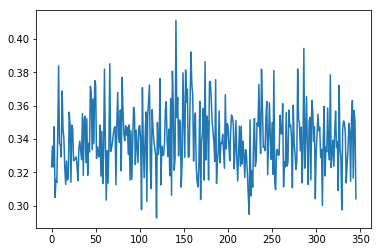

Epoch  5 Summary:  Training_auc : 0.7651009727862721  , Validation_auc :  0.7632724378243808  ,Test_auc :  0.7604940692130999 Test_auc on short visits: 0.7491199420151613 Test_auc on long visits: 0.7781236139370998  Avg Loss:  0.339441210093703 Train Time (6m 54s) Eval Time (4m 15s)

 Current running on: Epoch  6 Training loss:  Average loss 0.33948282565224636


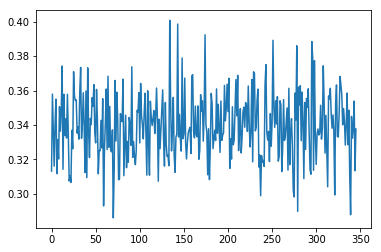

Epoch  6 Summary:  Training_auc : 0.7674088773106139  , Validation_auc :  0.7640616383934637  ,Test_auc :  0.7622432289904918 Test_auc on short visits: 0.748665001796665 Test_auc on long visits: 0.781795146285801  Avg Loss:  0.33948282565224636 Train Time (7m 19s) Eval Time (3m 41s)

 Current running on: Epoch  7 Training loss:  Average loss 0.33932705707522925


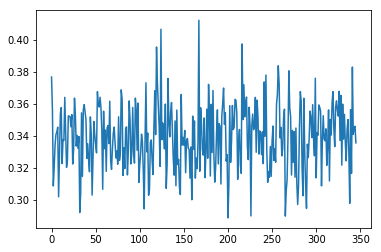

Epoch  7 Summary:  Training_auc : 0.7673443557985614  , Validation_auc :  0.7641290975868787  ,Test_auc :  0.7620310428496504 Test_auc on short visits: 0.7486707680574092 Test_auc on long visits: 0.7816930788155867  Avg Loss:  0.33932705707522925 Train Time (7m 33s) Eval Time (4m 27s)

 Current running on: Epoch  8 Training loss:  Average loss 0.3393939889361028


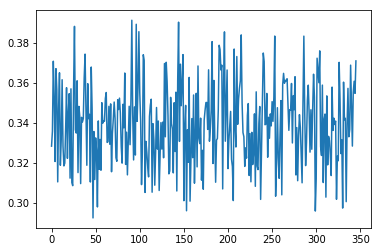

Epoch  8 Summary:  Training_auc : 0.7685250134523803  , Validation_auc :  0.7646799759987015  ,Test_auc :  0.7622759292111749 Test_auc on short visits: 0.7510303883392431 Test_auc on long visits: 0.7794090617609986  Avg Loss:  0.3393939889361028 Train Time (7m 27s) Eval Time (3m 42s)

 Current running on: Epoch  9 Training loss:  Average loss 0.3393986804896512


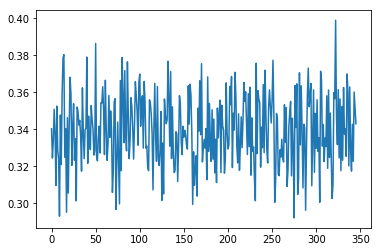

Epoch  9 Summary:  Training_auc : 0.7648870276741241  , Validation_auc :  0.7637161987039405  ,Test_auc :  0.7610460716571957 Test_auc on short visits: 0.7494893331555812 Test_auc on long visits: 0.7801701115121942  Avg Loss:  0.3393986804896512 Train Time (6m 22s) Eval Time (3m 50s)

 Current running on: Epoch  10 Training loss:  Average loss 0.33943329690947216


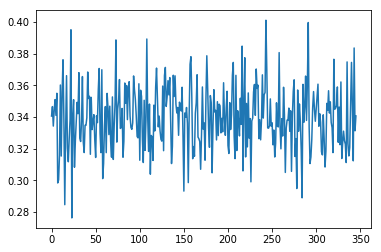

Epoch  10 Summary:  Training_auc : 0.7699386212994808  , Validation_auc :  0.7679232214111108  ,Test_auc :  0.7650055951169954 Test_auc on short visits: 0.7507762467653053 Test_auc on long visits: 0.783876022853  Avg Loss:  0.33943329690947216 Train Time (7m 12s) Eval Time (4m 25s)

 Current running on: Epoch  11 Training loss:  Average loss 0.33942200374006537


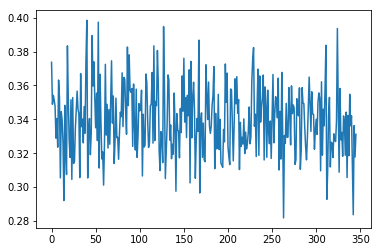

Epoch  11 Summary:  Training_auc : 0.7553763173727652  , Validation_auc :  0.7522943091401995  ,Test_auc :  0.750501956518138 Test_auc on short visits: 0.7490917884593569 Test_auc on long visits: 0.7666537966305539  Avg Loss:  0.33942200374006537 Train Time (7m 16s) Eval Time (3m 47s)

 Current running on: Epoch  12 Training loss:  Average loss 0.33934539140263115


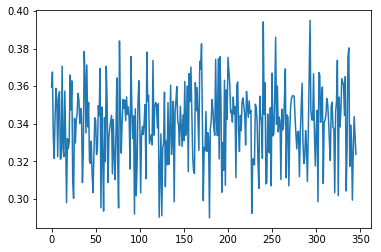

Epoch  12 Summary:  Training_auc : 0.7672253012711602  , Validation_auc :  0.7628021046610116  ,Test_auc :  0.7620491299205097 Test_auc on short visits: 0.7508075590277987 Test_auc on long visits: 0.7803489348082792  Avg Loss:  0.33934539140263115 Train Time (6m 45s) Eval Time (3m 55s)

 Current running on: Epoch  13 Training loss:  Average loss 0.33948090721703733


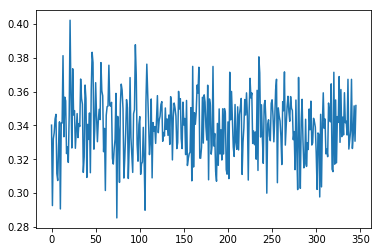

Epoch  13 Summary:  Training_auc : 0.766143310909984  , Validation_auc :  0.7642836282265303  ,Test_auc :  0.7613979419462684 Test_auc on short visits: 0.750249537828412 Test_auc on long visits: 0.779287063012649  Avg Loss:  0.33948090721703733 Train Time (7m 16s) Eval Time (4m 3s)

 Current running on: Epoch  14 Training loss:  Average loss 0.33941011388551523


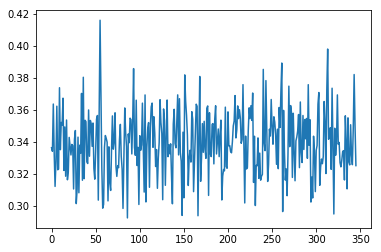

Epoch  14 Summary:  Training_auc : 0.7655286686434206  , Validation_auc :  0.764875228990536  ,Test_auc :  0.7607611656128743 Test_auc on short visits: 0.7469201652600759 Test_auc on long visits: 0.7799599043101634  Avg Loss:  0.33941011388551523 Train Time (7m 32s) Eval Time (4m 17s)

 Current running on: Epoch  15 Training loss:  Average loss 0.33945985778941995


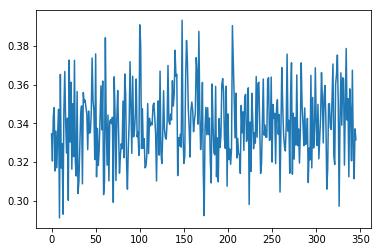

Epoch  15 Summary:  Training_auc : 0.7659888988209884  , Validation_auc :  0.7633331127640546  ,Test_auc :  0.7614446212664367 Test_auc on short visits: 0.7493832617470975 Test_auc on long visits: 0.7802192102856089  Avg Loss:  0.33945985778941995 Train Time (7m 18s) Eval Time (3m 42s)

 Current running on: Epoch  16 Training loss:  Average loss 0.33952425084650045


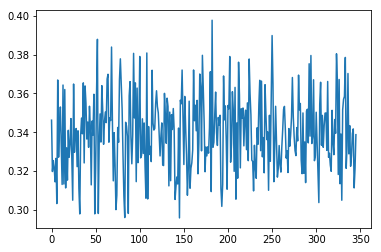

Epoch  16 Summary:  Training_auc : 0.7646261405040953  , Validation_auc :  0.761756906971504  ,Test_auc :  0.7598274826726508 Test_auc on short visits: 0.748240172729321 Test_auc on long visits: 0.7781049046165911  Avg Loss:  0.33952425084650045 Train Time (7m 36s) Eval Time (3m 46s)

 Current running on: Epoch  17 Training loss:  Average loss 0.33920388982828714


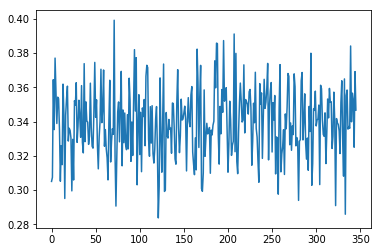

Epoch  17 Summary:  Training_auc : 0.7664091599338402  , Validation_auc :  0.7603246309546416  ,Test_auc :  0.7602436455723427 Test_auc on short visits: 0.7496544087727345 Test_auc on long visits: 0.7774855362786203  Avg Loss:  0.33920388982828714 Train Time (7m 52s) Eval Time (4m 38s)

 Current running on: Epoch  18 Training loss:  Average loss 0.3392701186837661


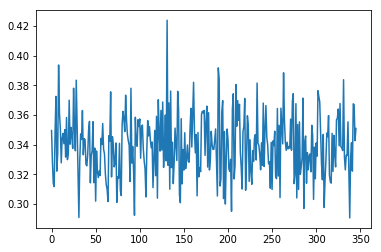

Epoch  18 Summary:  Training_auc : 0.7660780911457223  , Validation_auc :  0.7619600643295357  ,Test_auc :  0.7607803141205534 Test_auc on short visits: 0.7519526071847678 Test_auc on long visits: 0.7782148925299995  Avg Loss:  0.3392701186837661 Train Time (7m 54s) Eval Time (3m 41s)

 Current running on: Epoch  19 Training loss:  Average loss 0.3392972386434653


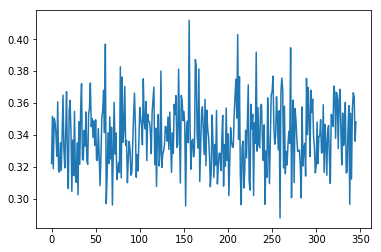

Epoch  19 Summary:  Training_auc : 0.7674540847211125  , Validation_auc :  0.7639018811856738  ,Test_auc :  0.761841478668898 Test_auc on short visits: 0.7492807072173219 Test_auc on long visits: 0.7805794579353752  Avg Loss:  0.3392972386434653 Train Time (7m 59s) Eval Time (4m 28s)


In [10]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, _ = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
    #emb_wdf = pd.DataFrame(emb.weight)
    #emb_wdf.columns = ['emb_w']
    #print(emb_wdf.head())
    #emb_wdf.to_csv('embedding weight at Epoch'+str(ep), sep='\t')
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [11]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

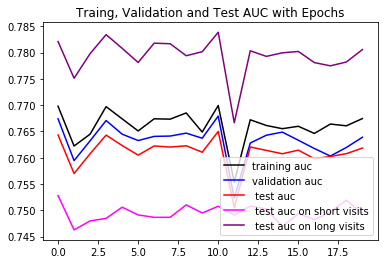

In [12]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [13]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim1_Biggestdata_unbalanced')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/44/training-auc-validation-auc-test-auc-test-auc-on-5-visits/>**

Or you can see a static plot here:

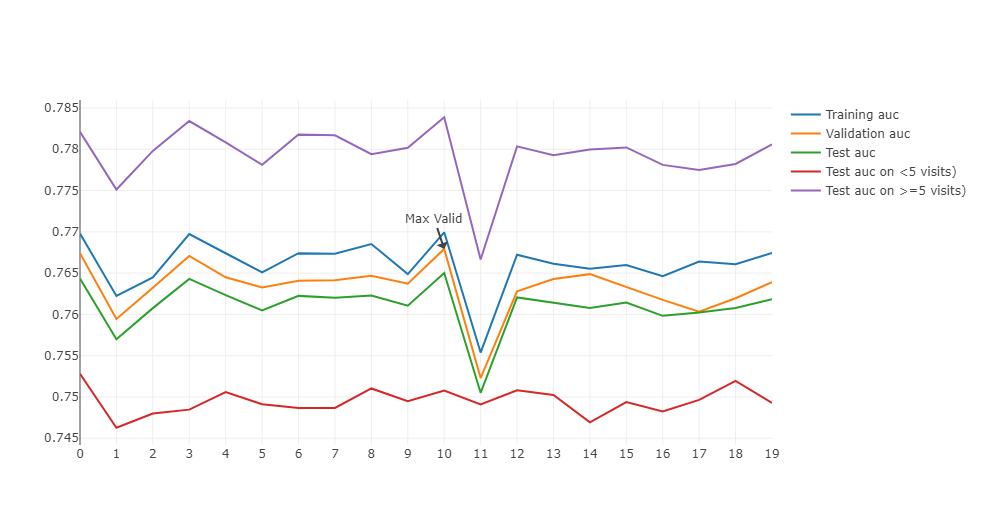

In [1]:
from IPython.display import Image
Image('img/LR_Auc_dim1_biggestdata_unbalanced.png')

In [14]:
#extract weights
torch.save(ehr_model, 'Lr1model_dim1_biggestdata_unbalanced')
z= pd.DataFrame(ehr_model.embedding.weight.cpu().data.numpy())
z.to_csv('embedding weights_dim1_biggestdata_unbalanced')
ehr_model.embedding.weight

Parameter containing:
 0.0000
-0.0000
 0.0036
   ⋮    
-0.0000
 0.0000
-0.0000
[torch.cuda.FloatTensor of size 20000x1 (GPU 0)]